In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skvideo.io import vread, vwrite
from skimage.color import rgb2gray

In [15]:
cap = cv2.VideoCapture('data/video2.mp4')
filtered_vid = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if frame is None:
        break
    frame = frame[:, 320:, :]
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    lower_orange = np.array([0, 70, 70])
    upper_orange = np.array([30, 255, 255])
 
    # preparing the mask to overlay
    mask = cv2.inRange(hsv, lower_orange, upper_orange)
     
    # The black region in the mask has the value of 0,
    # so when multiplied with original image removes all non-blue regions
    result = cv2.bitwise_and(frame, frame, mask = mask)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)
    
    locations = []
    for contour in contours:
        area = cv2.contourArea(contour)
#         print(area)
        if area > 9:
            locations.append(area)
#     print(len(locations))
    
#     plt.imshow(result)
#     plt.show()
    filtered_vid.append(result)
     
#     cv2.waitKey(0)
    
cap.release()
# cv2.destroyAllWindows()

In [17]:
video_filename = "data/video2.mp4"
video = vread(video_filename)[:, :, 320:, :]
filtered_vid = np.array(filtered_vid)
print(filtered_vid.shape)
print(video.shape)

(344, 720, 960, 3)
(344, 720, 960, 3)


In [4]:
# video = filtered_vid

In [18]:
from skimage.feature import corner_harris, peak_local_max, corner_peaks


def get_harris_corners(im, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """

    assert edge_discard >= 20

    # find harris corners
    h = corner_harris(im, method='eps', sigma=10)
    #vid 1
    coords = corner_peaks(h, min_distance=7, indices=True)
    # vid2
#     coords = peak_local_max(h, min_distance=25, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert dimx == dimc, 'Data dimension does not match dimension of centers'

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)



In [19]:
def show_harris(video):
    h_scores, h_coords = get_harris_corners(rgb2gray(video[0]))
    plt.figure(figsize=(15,15))
    plt.imshow(video[0])
    plt.scatter(h_coords[1], h_coords[0])
    for i in range(h_coords.shape[1]):
        plt.annotate(i, (h_coords[1][i], h_coords[0][i]), color='yellow')
    return h_coords

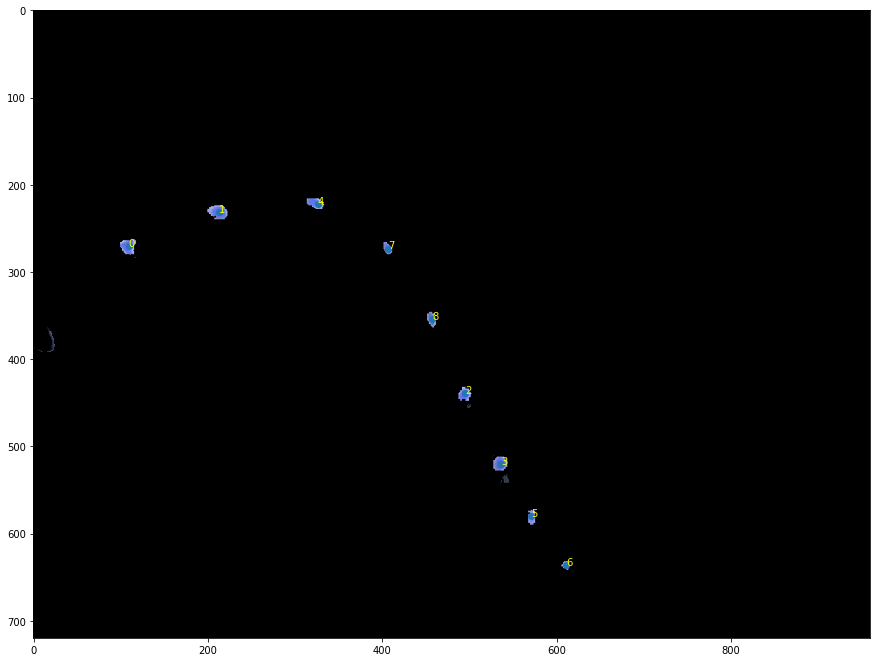

In [21]:
h_coords = show_harris(filtered_vid)

In [22]:
def track(video, initial_pt):
    frame = video[0]
#     tracker = cv2.TrackerMedianFlow_create()
    tracker = cv2.legacy.TrackerMedianFlow_create()
    points = [tuple(initial_pt)]
    bbox_size = 10
    bbox = (initial_pt[1]-bbox_size//2, initial_pt[0]-bbox_size//2, bbox_size, bbox_size)
    ok = tracker.init(frame, bbox)
    for i in range(len(video)):
        ok, bbox = tracker.update(video[i])
        if not ok:
            print("tracking failure")
            raise ValueError
        points.append((bbox[1] + 4, bbox[0] + 4))
    return points

In [23]:
def get_all_tracked(video, h_coords, indices_to_track):
    all_tracked = []
    for idx in indices_to_track:
        all_tracked.append(track(video, h_coords[:,idx]))
    all_tracked = np.asarray(all_tracked)
    return all_tracked

In [24]:
h_coords.shape

(2, 9)

In [25]:
all_tracked = get_all_tracked(video, h_coords, range(9))

In [26]:
print(all_tracked.shape)

(9, 345, 2)


In [29]:
from skimage.draw import circle
def draw_points(video, points, idx):
    frame = video[idx].copy()
    for pt in points:
        r,c = circle(pt[0], pt[1], 5)
        frame[r,c] = (0,255,0)
    plt.figure()
    plt.imshow(frame)
    return frame

<ipython-input-29-a10d2e52f181>:5: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  r,c = circle(pt[0], pt[1], 5)


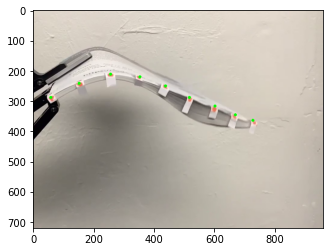

In [33]:
idx = 200
frame = draw_points(video, all_tracked[:,idx],idx)